## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import applications
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Convolution2D, MaxPool2D, Flatten
from keras.models import Model
from keras.layers import Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.utils import compute_class_weight
from keras.optimizers import Adam



#Make sure we are running on the
print(torch.cuda.is_available())
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(torch.cuda.get_device_name(cuda_id))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
NVIDIA A100-SXM4-40GB
cuda


# Import Data

In [3]:
!unzip '/content/drive/MyDrive/Biomedical AI/Resized_Data.zip' > /dev/null

In [4]:
!pip install split-folders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import splitfolders

# Define the input folder
input_folder = '/content/train'

# Define the output folder
output_folder = '/content/splitData'

# Split the data into training and validation sets
splitfolders.ratio(input_folder, output_folder, seed=1337, ratio=(.8, .2))

Copying files: 16764 files [00:01, 8859.40 files/s]


In [27]:
#create a data generator from ImageDataGenerator which performs augmentation
#rescaling /255 to get pixel values between 0 and 1
#horizontal and vertical flip set to true
#rotation range set to 30 degrees
data_gen1 = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 30,
    fill_mode = 'constant')

#data generator to augment validation and test images. only rescaling is applied
data_gen2 = ImageDataGenerator(rescale = 1./255)

#create a training generator which generates a batch of images from the training data
#target size set to 128, 128 and color mode rgb sets depth to 3
#shuffle set to true to add variance
train_gen = data_gen1.flow_from_directory(
    directory='/content/Resized_Data/train',
    target_size = (128, 128),
    class_mode = 'categorical',
    color_mode = 'rgb',
    batch_size = 50,
    shuffle = True)
#grab number of samples
train_num = train_gen.samples

#create a validating generator which generates a batch of images from the validation data
#target size set to 128, 128 and color mode rgb sets depth to 3
#shuffle set to true to add variance
validate_gen = data_gen2.flow_from_directory(
    directory='/content/Resized_Data/val',
    target_size = (128, 128),
    class_mode = 'categorical',
    color_mode = 'rgb',
    batch_size = 50,
    shuffle = True)
#grab number of samples
validate_num = validate_gen.samples

#create a testing generator which generates a batch of images from the test data
#target size set to 128, 128 and color mode rgb sets depth to 3
#shuffle set to true to add variance
test_gen = data_gen2.flow_from_directory(
    directory='/content/Resized_Data/test',
    target_size = (128, 128),
    class_mode = 'categorical',
    color_mode = 'rgb',
    batch_size = 50,
    shuffle = True)
#grab the number of samples
test_num = test_gen.samples

Found 13410 images belonging to 2 classes.
Found 3354 images belonging to 2 classes.
Found 930 images belonging to 2 classes.


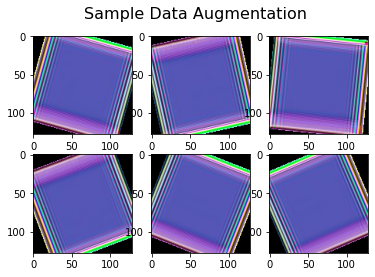

y Labels:  [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [28]:
#visualize the augmented data
# Get the next batch of images from the train generator
train_images, train_labels = train_gen.next()

#grab the first 8 in the batch and their labels and plot them
for k in range(1,7):
    sample_img = train_images[k,:,:,:]
    plt.subplot(2, 3, k)
    plt.imshow(sample_img)
plt.suptitle('Sample Data Augmentation', fontsize = 16)    
plt.show()

print('y Labels: ', train_labels[1:7])

# build model

In [11]:
#specify the dimensions of the input
image_input = Input(shape=(128,128,3))
# Load the ResNet50 model
#include_top set to false to exclude the classification layers of resnet
#weights set to imagenet
base_model = tf.keras.applications.resnet50.ResNet50(input_tensor = image_input, weights='imagenet', include_top=False)

# Freeze ResNet's layers so their paramteres dont get retrained
# for layer in base_model.layers[:-6]:
    # layer.trainable = False

#grab the output of the last layer of ResNet
base_output = base_model.layers[-1].output
#flatten the output
flat1 = Flatten()(base_output)
#pass through dense layers 
#activation set to relu as it maps negative values to zero, making it effecient and helps in generalization
#dropout used to help in generalization
fc1 = Dense(500, activation = 'relu')(flat1)
dropfc1 = Dropout(0.5)(fc1)
fc2 = Dense(100, activation = 'relu')(dropfc1)
dropfc2 = Dropout(0.5)(fc2)
#softmax set as final activation fucntion as it calcs the porb of belonging to each class and outputs class of highest probability
predictions = Dense(2, activation = 'sigmoid')(dropfc2)

# Create new model
model = Model(inputs=base_model.input, outputs=predictions)

#model.summary()

94765736/94765736 [==============================] - 1s 0us/step


In [29]:
# Compile the model

#optimizer set to Adam is it is usually standard
#learning rate was set to 1e-4 through trial and error process
#binary crossentropy as this is a binary classification
opt = Adam(lr = 1e-4)
model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['accuracy'])

#define early stop
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Define the checkpoint callback
checkpoint = ModelCheckpoint('best_model.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

# Training

In [30]:
# Train the  using .fit()
history = model.fit(
    train_gen,
    epochs = 20,
    steps_per_epoch = train_num // 50,
    validation_data = validate_gen,
    validation_steps = validate_num // 50,
    callbacks=[early_stop, checkpoint])

Epoch 1/20
268/268 [==============================] - 70s 203ms/step - loss: 0.7938 - accuracy: 0.6045 - val_loss: 0.6575 - val_accuracy: 0.6469
Epoch 2/20
268/268 [==============================] - 52s 193ms/step - loss: 0.6782 - accuracy: 0.6393 - val_loss: 0.6833 - val_accuracy: 0.6466
Epoch 3/20
268/268 [==============================] - 52s 193ms/step - loss: 0.6620 - accuracy: 0.6447 - val_loss: 0.6806 - val_accuracy: 0.6469
Epoch 4/20
268/268 [==============================] - 53s 199ms/step - loss: 0.6494 - accuracy: 0.6450 - val_loss: 0.6354 - val_accuracy: 0.6469
Epoch 5/20
268/268 [==============================] - 52s 193ms/step - loss: 0.6384 - accuracy: 0.6465 - val_loss: 0.6388 - val_accuracy: 0.6475
Epoch 6/20
268/268 [==============================] - 53s 199ms/step - loss: 0.6399 - accuracy: 0.6476 - val_loss: 0.6338 - val_accuracy: 0.6269
Epoch 7/20
268/268 [==============================] - 52s 194ms/step - loss: 0.6272 - accuracy: 0.6561 - val_loss: 0.6453 - val_ac

# Plotting

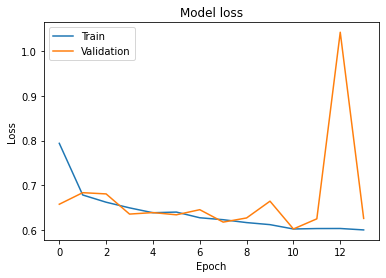

In [31]:
#plotting validation and training losses obtained from training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

<ipython-input-32-d2e301de19a5>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predictions = model.predict_generator(test_gen)


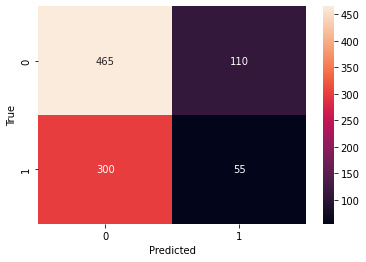

In [32]:
#using the test generator plot a confusion matrix

# Generate predictions on test data
test_predictions = model.predict_generator(test_gen)
test_predictions = np.argmax(test_predictions, axis=1)
test_labels = test_gen.classes

# Plot the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()